In [1]:
import glob
import gsw
import warnings
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import os
import zarr

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    lon          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    max_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    min_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    raising      (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    salinity     (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    temperature  (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] 196kB dask.array<chunk

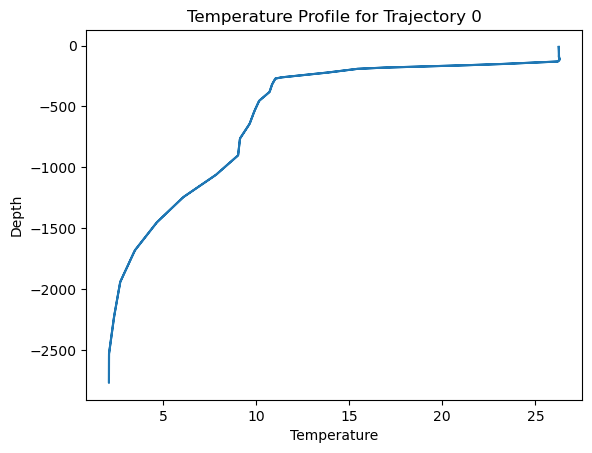

{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:12:00'), 'temperature': 26.256418228149414, 'salinity': 34.966346740722656, 'z': -11.0, 'trajectory': 38, 'obs': 0}


In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Open the Zarr dataset
datadir = r"C:\Users\gvp63\Downloads\results (2)\somalia\results\ctd.zarr"
ds = xr.open_zarr(datadir)

# Inspect dataset
print(ds)

# Count the number of trajectories and observations
num_trajectories = ds.sizes['trajectory']
num_observations = ds.sizes['obs']
print(f"Number of trajectories: {num_trajectories}")
print(f"Number of observations per trajectory: {num_observations}")

# Plot temperature vs depth for the first trajectory
plt.plot(ds['temperature'].isel(trajectory=0), ds['z'].isel(trajectory=0))
plt.xlabel('Temperature')
plt.ylabel('Depth')
plt.title('Temperature Profile for Trajectory 0')
plt.show()

# Reshape dataset to avoid looping
ds_stacked = ds.stack(points=("trajectory", "obs")).reset_index("points")

# Convert to a dictionary efficiently
df = ds_stacked[['lat', 'lon', 'time', 'temperature', 'salinity', 'z']].to_dataframe()
df = df.reset_index(drop=True)  # Drop unnecessary index columns
data = df.to_dict(orient='records')

# Check the first profile
print(data[0])


c:\Users\gvp63\anaconda3\envs\dyoc\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


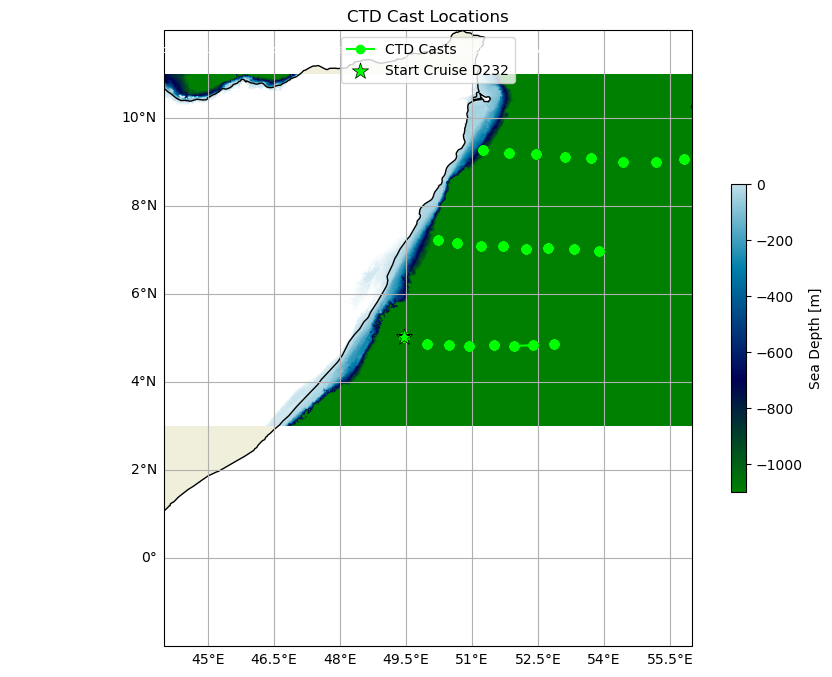

In [8]:
# Load bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot bathymetry
tp = ax.pcolormesh(bathy.lon, bathy.lat, bathy.elevation, cmap='ocean', vmin=-1100, vmax=100, transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.gridlines(draw_labels=['left', 'bottom'], zorder=0)

# Plot CTD cast locations
if data:
    ax.plot([profile['lon'] for profile in data], [profile['lat'] for profile in data], '-o',
            transform=ccrs.PlateCarree(), c='lime', label='CTD Casts')
    ax.scatter(data[0]['lon'], data[0]['lat'], c='lime', marker='*', s=150, zorder=2,
               transform=ccrs.PlateCarree(), edgecolors='k', linewidths=.5, label='Start Cruise D232')
    ax.legend(loc='upper center')
else:
    print("Warning: No CTD data found. Skipping CTD cast locations.")

# Set title and extent
ax.set_title('CTD Cast Locations')
ax.set_extent([44, 56, -2, 12])  # [min_lon, max_lon, min_lat, max_lat]

# Add colorbar
cb = fig.colorbar(tp, ax=ax, shrink=.5)
cb.ax.set_ylim([-1100, 0])
cb.set_label('Sea Depth [m]')

info_text = bathy.attrs.get('title', 'GEBCO 2024 Grid')  # Use 'title' or another available attribute
_ = ax.text(40.5, 11.5, info_text, c='w', fontsize=8)  # Adjust position as needed

plt.show()

In [36]:
from collections import defaultdict

# Group data points by trajectory
grouped_data = defaultdict(list)
for obs in data:
    trajectory = obs['trajectory']
    grouped_data[trajectory].append(obs)

# Convert to a list of profiles (each profile is a trajectory with multiple depth levels)
profiles = []
for trajectory, observations in grouped_data.items():
    # Extract valid (non-NaN) observations
    valid_obs = [
        obs for obs in observations
        if not (np.isnan(obs['salinity']) or 
             np.isnan(obs['temperature']) or 
             np.isnan(obs['z']))
    ]
    
    if not valid_obs:
        continue  # Skip trajectories with no valid data
        
    profiles.append({
        'salinity': np.array([obs['salinity'] for obs in valid_obs]),
        'temperature': np.array([obs['temperature'] for obs in valid_obs]),
        'z': np.array([obs['z'] for obs in valid_obs]),
        'trajectory': trajectory
    })


# Constants
alpha_T = 1e-4  # Thermal expansion coefficient
beta_S = 7e-4   # Haline contraction coefficient
dens0 = 1027    # Reference density (kg/m³)

def calc_density(profile):
    """
    Calculate density from a profile containing salinity, temperature, and depth.
    
    Parameters:
        profile (dict): A dictionary containing 'salinity', 'temperature', 'z', and 'trajectory'.
    """
    S = profile['salinity']
    T = profile['temperature']
    depth = profile['z']

    # Reference salinity and temperature (surface value)
    S0 = S[0]
    T0 = T[0]

    # Calculate density
    dens = dens0 * (1 - (alpha_T * (T - T0)) + (beta_S * (S - S0)))

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")
    plt.xlabel('Density (kg/m³)')
    plt.ylabel('Depth (m)')
    plt.title('Density Profile')
    plt.grid()
    plt.legend()
    plt.show()

    return dens

In [34]:
data

[{'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:00'),
  'temperature': 26.256418228149414,
  'salinity': 34.966346740722656,
  'z': -11.0,
  'trajectory': 38,
  'obs': 0},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:10'),
  'temperature': 26.260557174682617,
  'salinity': 34.970802307128906,
  'z': -21.0,
  'trajectory': 38,
  'obs': 1},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:20'),
  'temperature': 26.26323127746582,
  'salinity': 34.97873306274414,
  'z': -31.0,
  'trajectory': 38,
  'obs': 2},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:30'),
  'temperature': 26.26406478881836,
  'salinity': 34.988609313964844,
  'z': -41.0,
  'trajectory': 38,
  'obs': 3},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:40'),
  'temperature': 26.265293

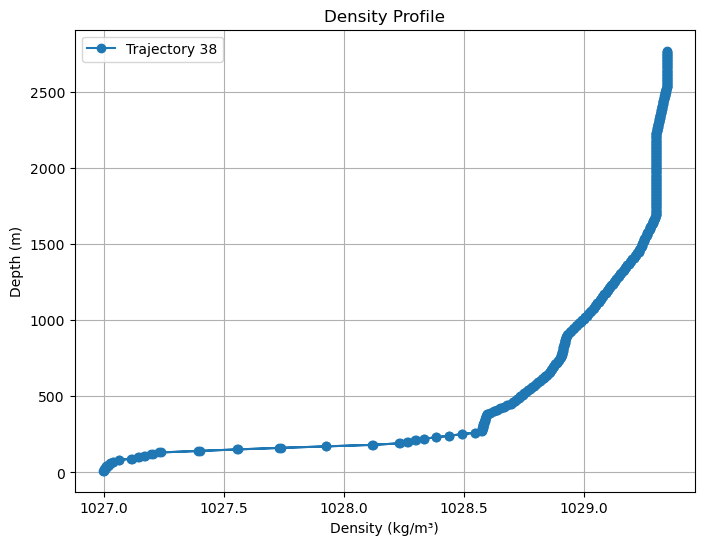

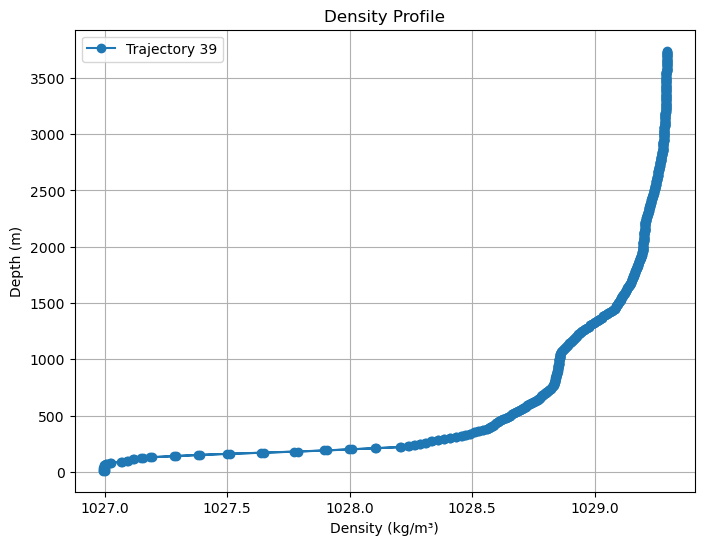

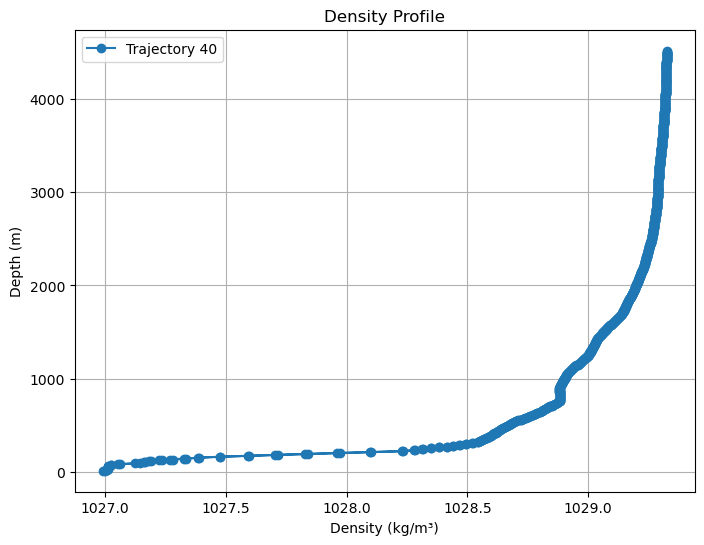

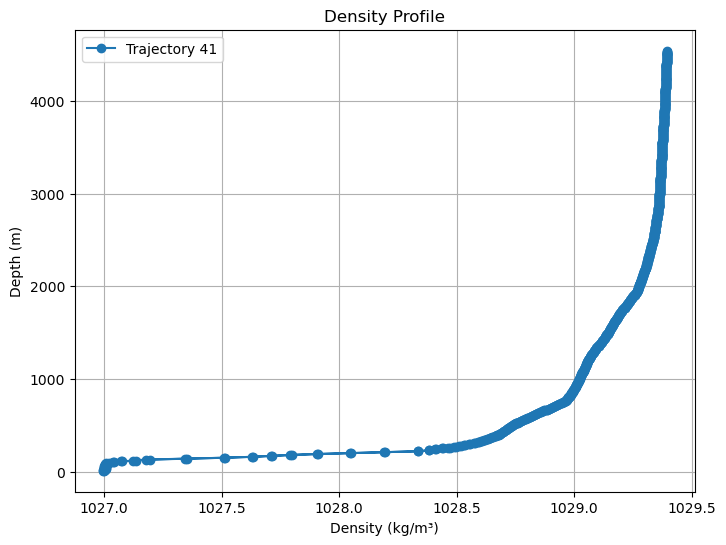

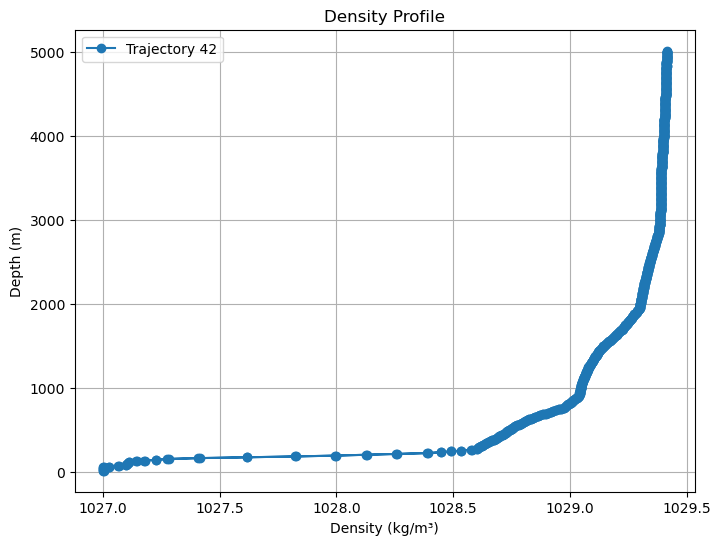

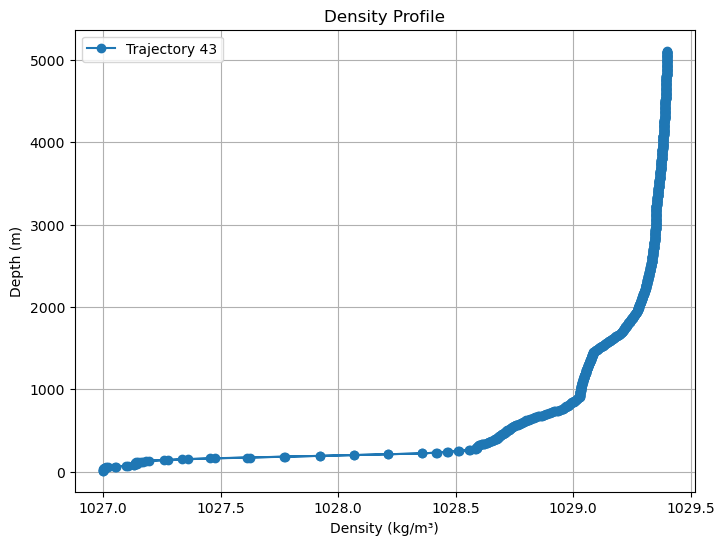

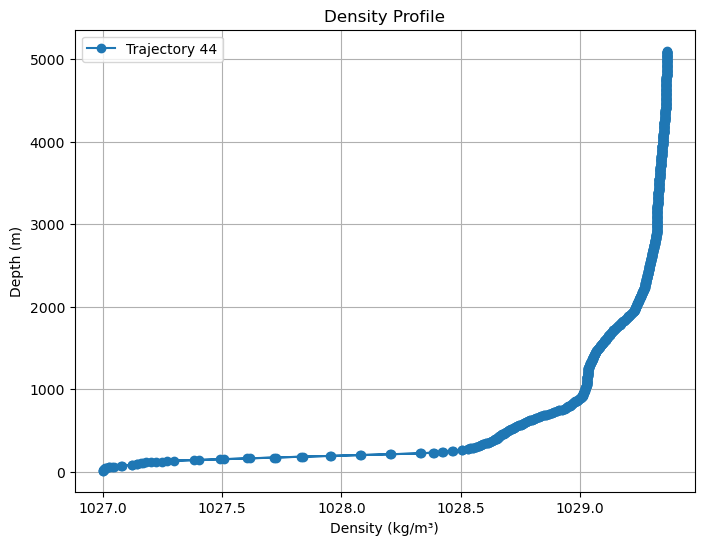

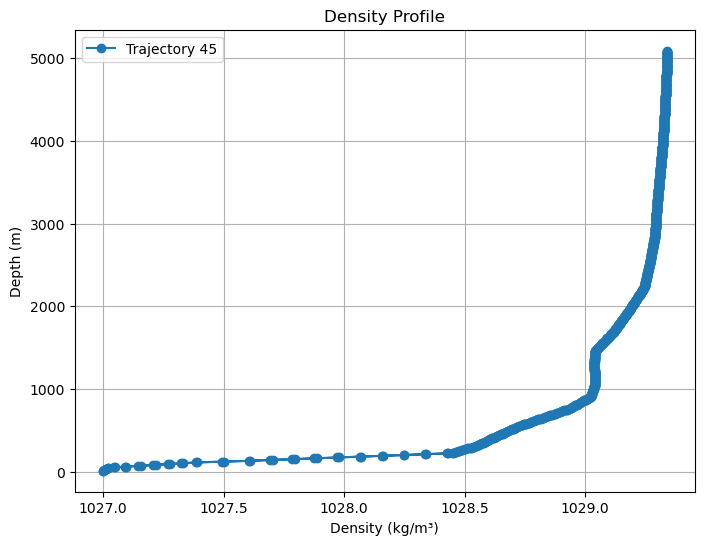

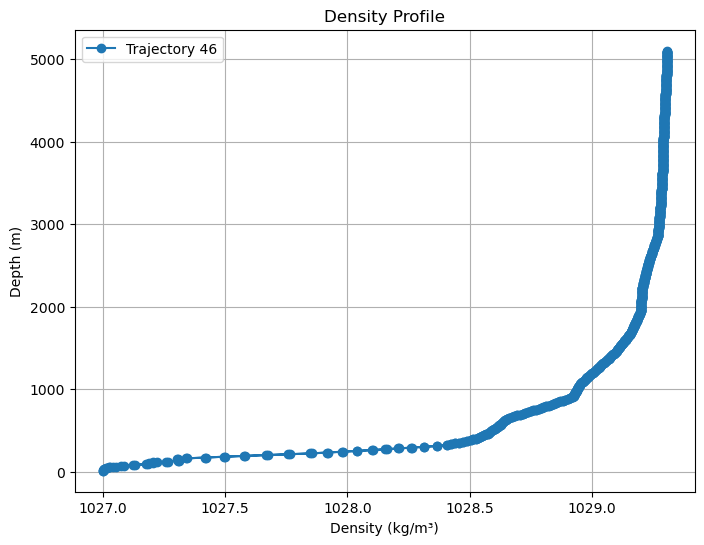

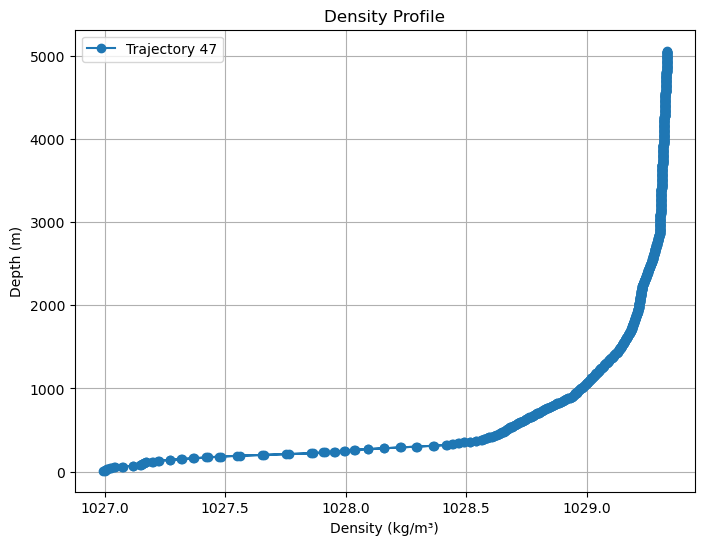

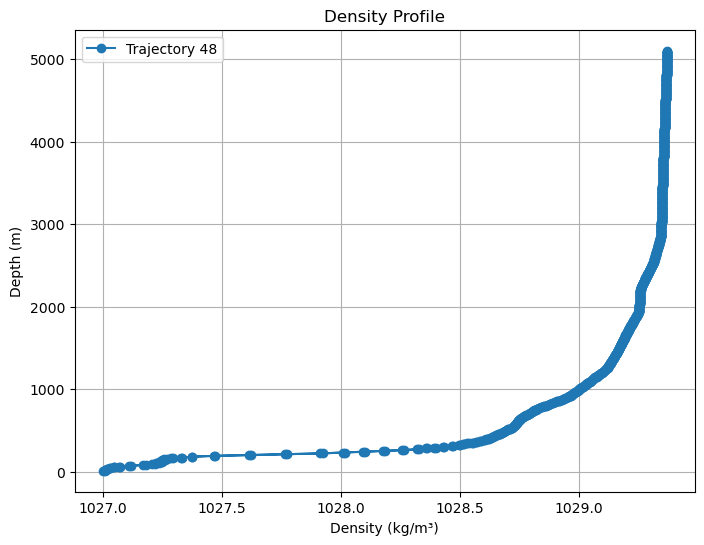

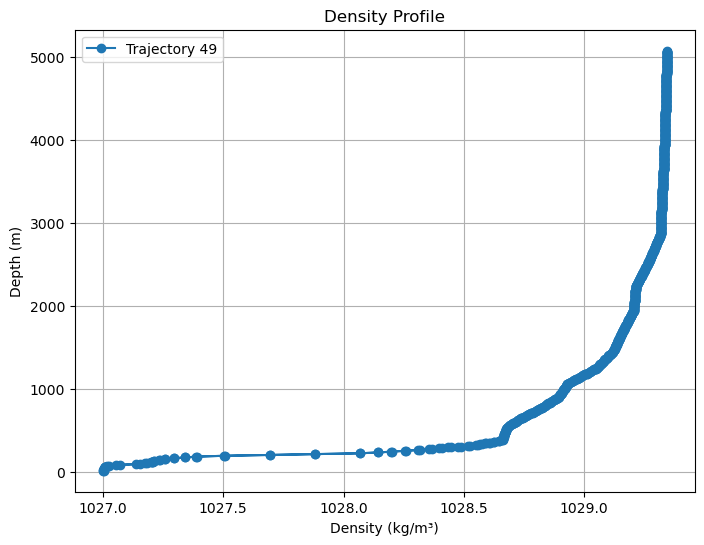

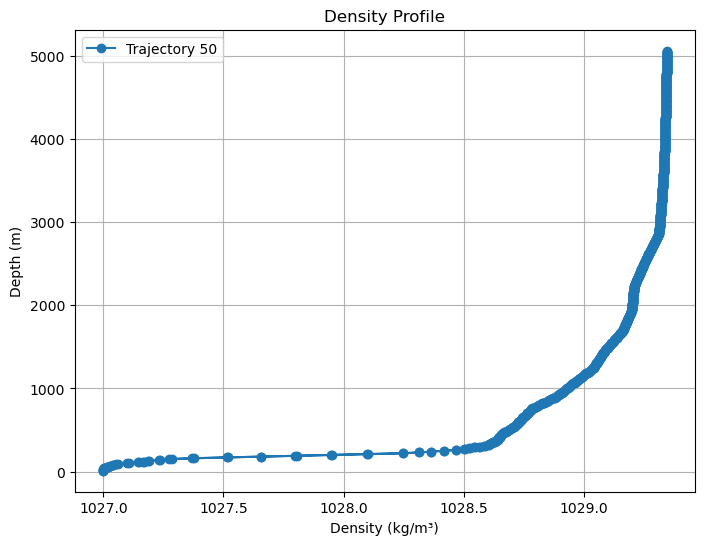

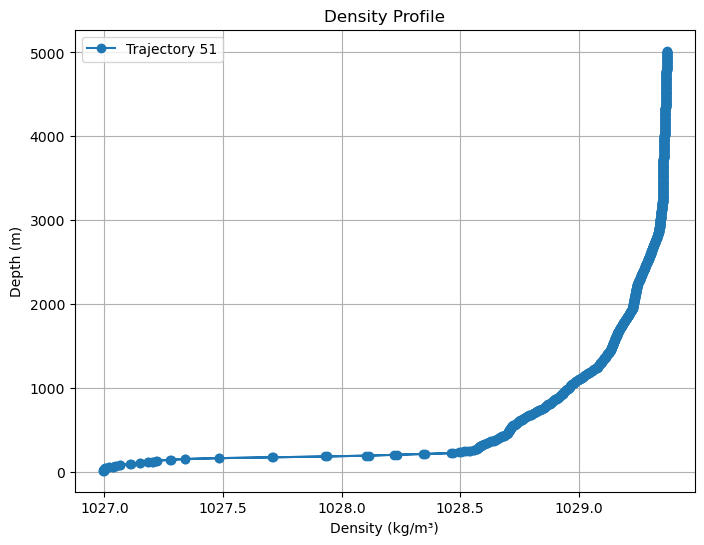

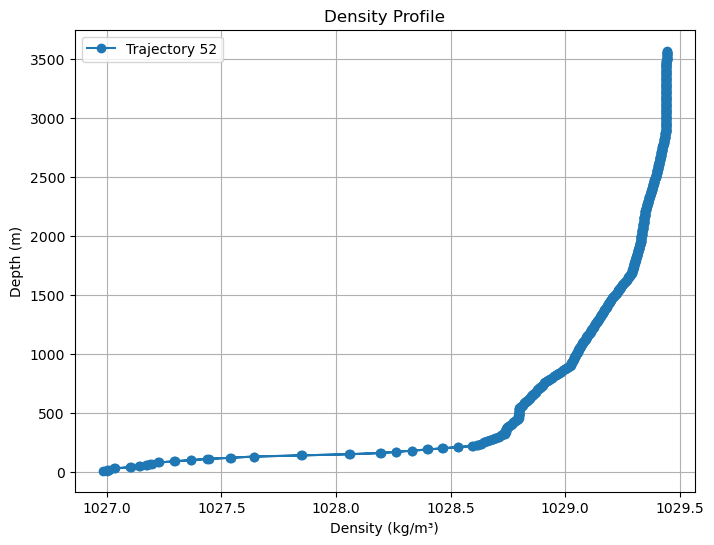

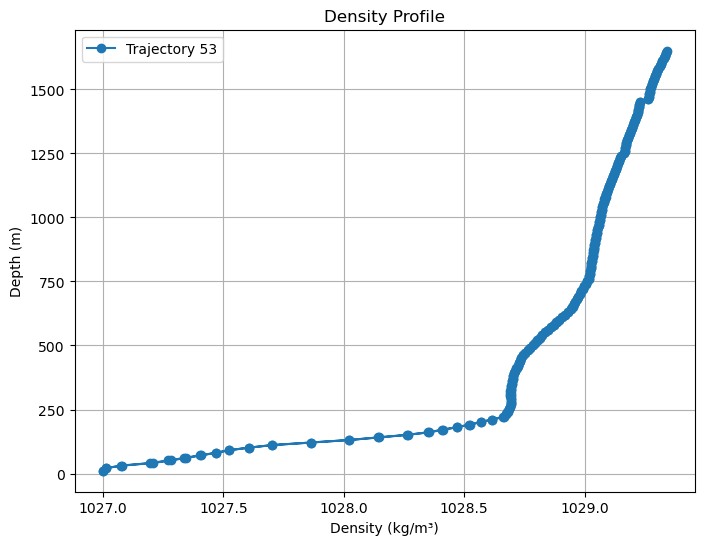

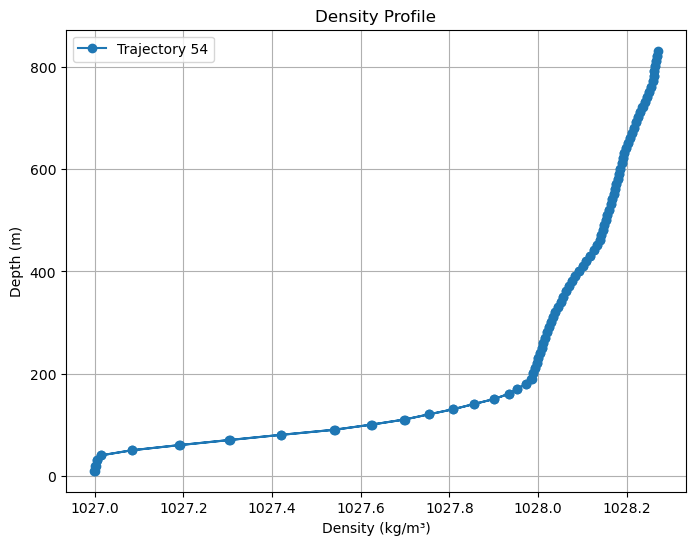

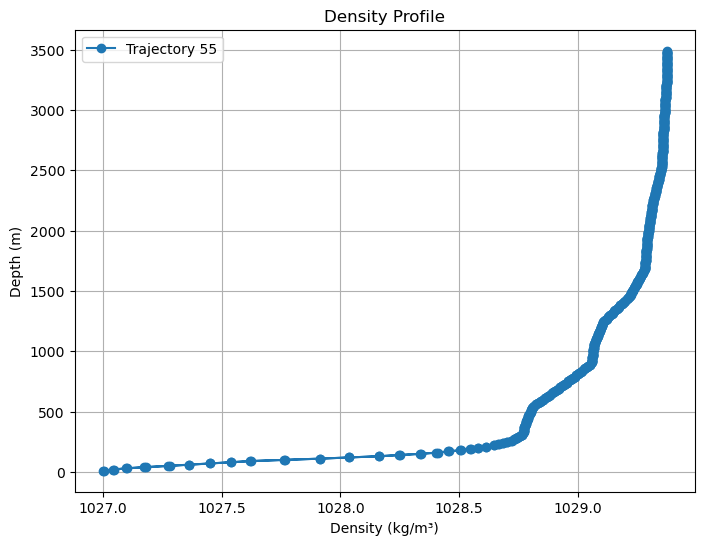

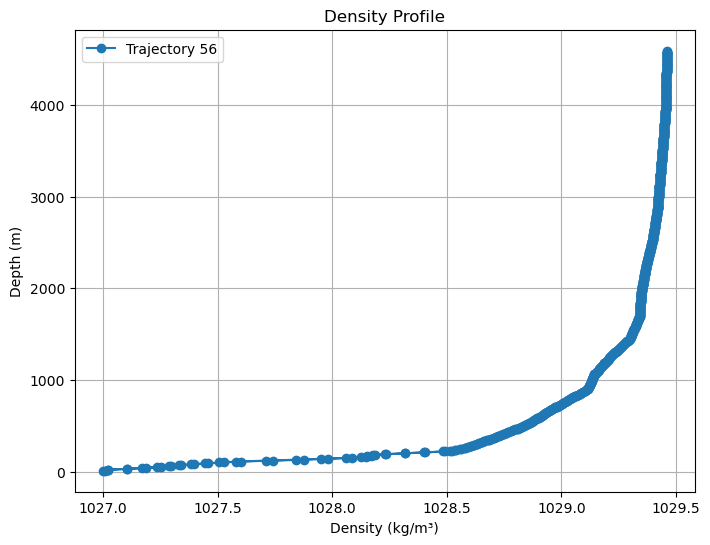

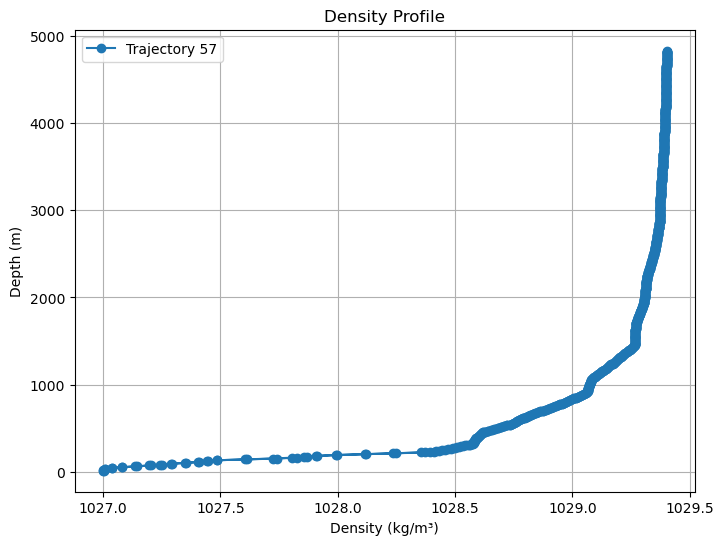

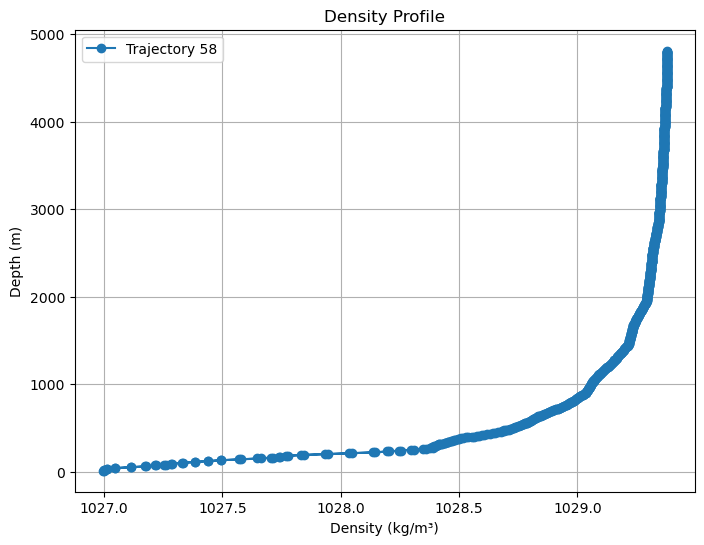

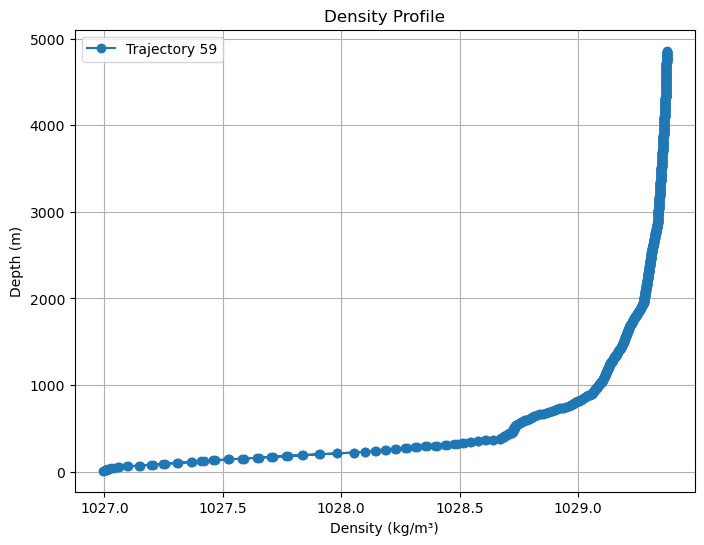

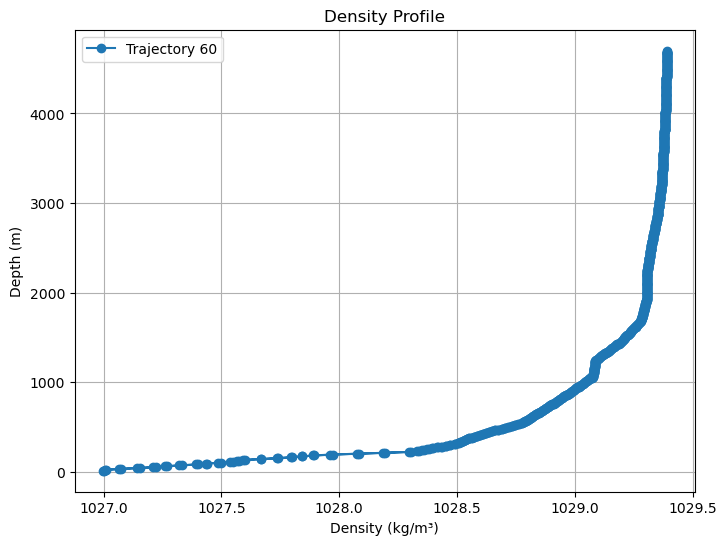

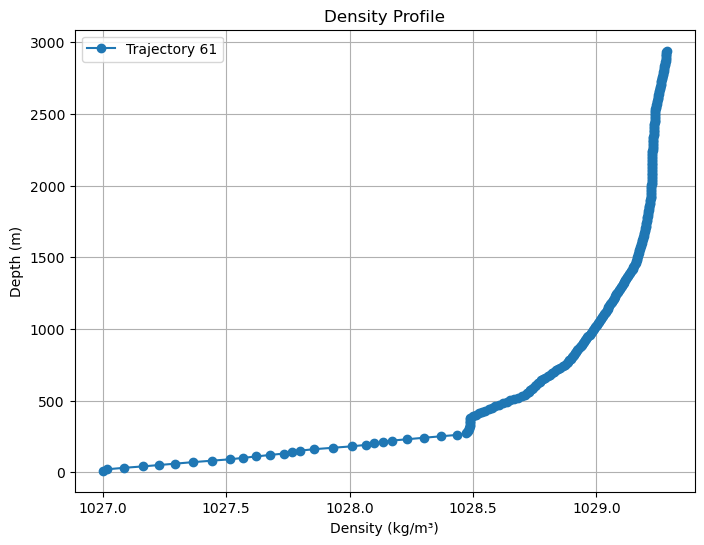

In [37]:
for profile in profiles:
    calc_density(profile)

In [38]:
# Constants
g = 9.81  # m/s²
rho0 = 1027  # kg/m³
f = 1e-4  # Coriolis parameter (adjust using f = 2Ωsin(latitude))
dx = 1e4  # Distance between stations (meters). Adjust based on your data!

# Group data by trajectory (assuming each trajectory is a station along the transect)
grouped_data = defaultdict(list)
for obs in data:
    trajectory = obs['trajectory']
    grouped_data[trajectory].append(obs)

# Sort trajectories to ensure correct station order (critical for gradients)
sorted_trajectories = sorted(grouped_data.keys())
profiles = []
for trajectory in sorted_trajectories:
    observations = grouped_data[trajectory]
    # Sort observations by depth (ascending)
    observations_sorted = sorted(observations, key=lambda x: x['z'])
    # Extract valid data (remove NaNs)
    valid_obs = [
        obs for obs in observations_sorted
        if not (np.isnan(obs['salinity']) or np.isnan(obs['temperature']) or np.isnan(obs['z']))
    ]
    if not valid_obs:
        continue
    # Calculate density for the profile
    salinity = np.array([obs['salinity'] for obs in valid_obs])
    temperature = np.array([obs['temperature'] for obs in valid_obs])
    z = np.array([obs['z'] for obs in valid_obs])
    dens = 1027 * (1 - 1e-4 * (temperature - temperature[0]) + 7e-4 * (salinity - salinity[0]))
    profiles.append({
        'trajectory': trajectory,
        'density': dens,
        'depth': z,
        'lat': valid_obs[0]['lat'],
        'lon': valid_obs[0]['lon']
    })

In [39]:
# Extract density and depth arrays for all stations
density_profiles = [profile['density'] for profile in profiles]
depth_profiles = [profile['depth'] for profile in profiles]

# Ensure all profiles have the same depth levels (interpolate if necessary)
# Example: Interpolate to a common depth grid (adjust resolution as needed)
common_depth = np.linspace(np.min([np.min(z) for z in depth_profiles]), 
                           np.max([np.max(z) for z in depth_profiles]), 
                           100)
density_interp = []
for dens, z in zip(density_profiles, depth_profiles):
    dens_interp = np.interp(common_depth, z, dens)
    density_interp.append(dens_interp)

density_interp = np.array(density_interp)  # Shape: (n_stations, n_depth_levels)

# Compute horizontal density gradient (∂ρ/∂x)
drho_dx = np.gradient(density_interp, dx, axis=0)  # axis=0: along stations

In [40]:
# Compute velocity shear (∂u/∂z)
du_dz = (-g / (rho0 * f)) * drho_dx

# Integrate vertically to get velocity (relative to bottom)
dz = np.gradient(common_depth)
u = np.cumsum(du_dz * dz, axis=1)  # Integrate from bottom to surface
u -= u[:, -1:]  # Assume no motion at the surface (adjust if using a different reference)

In [41]:
# Integrate velocity over depth at each station
transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s

# Integrate across the transect (assume constant dy = transect width)
dy = 1e4  # Adjust based on your transect!
total_transport = np.trapz(transport_per_station, dx=dx) * dy  # Units: m³/s

print(f"Total volume transport: {total_transport:.2f} m³/s")

Total volume transport: 181538653087.46 m³/s


C:\Users\gvp63\AppData\Local\Temp\ipykernel_12176\2367564791.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s
C:\Users\gvp63\AppData\Local\Temp\ipykernel_12176\2367564791.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_transport = np.trapz(transport_per_station, dx=dx) * dy  # Units: m³/s


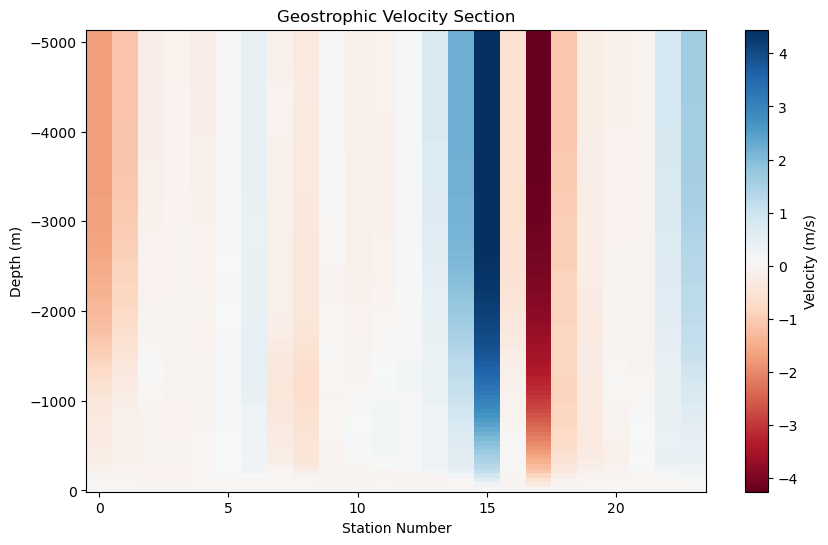

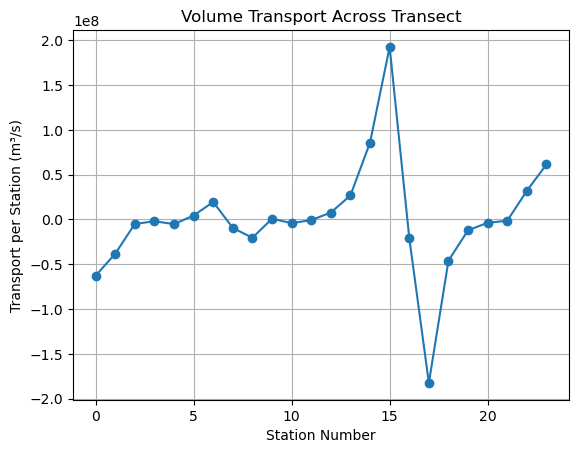

In [43]:
# Plot velocity section
plt.figure(figsize=(10, 6))
X, Z = np.meshgrid(np.arange(len(profiles)), common_depth)
plt.pcolormesh(X, Z, u.T, cmap='RdBu', shading='auto')
plt.colorbar(label='Velocity (m/s)')
plt.title('Geostrophic Velocity Section')
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.show()

# Plot transport
plt.figure()
plt.plot(np.arange(len(profiles)), transport_per_station * dy, 'o-')
plt.xlabel('Station Number')
plt.ylabel('Transport per Station (m³/s)')
plt.title('Volume Transport Across Transect')
plt.grid()
plt.show()